In [1]:
import numpy as np
from scipy import integrate    
import matplotlib.pyplot as plt
import itertools
import arviz as az
import seaborn as sns
import pickle
import pandas as pd
sns.set_style("darkgrid")
pd.set_option('display.precision',1)
pd.set_option('display.float_format', '{:.2g}'.format)

from rsindy.rsindy_bayes import *

### Model
$$
\begin{align*}
    X &\overset{k_1}{\to} 2X \\
    X + Y &\overset{k_2}{\to} 2Y \\
    Y &\overset{k_3}{\to} \phi \\
\end{align*}
$$

which can be translated into

$$
\begin{align*}
    \frac{dX}{dt} = k_1 X - k_2 XY \\
    \frac{dY}{dt} = k_2 X Y - k_3 Y 
\end{align*}
$$

In [2]:
def simulate_data(theta, t):
    
    Z0 = [100, 50]
    k1, k2, k3 = theta
    def dZdt(Z, t = 0):
        X, Y = Z

        dXdt = k1 * X - k2 * X * Y
        dYdt = k2 * X * Y - k3 * Y

        return [dXdt, dYdt]
    
    Z_obs = integrate.odeint(dZdt, Z0, t)
    Z_obs_noisy = Z_obs.copy()
    Z_obs_noisy[1:,:] = np.exp(np.log(Z_obs_noisy[1:,:]) + np.random.normal(0, 0.2, size = Z_obs_noisy[1:,:].shape))
    
    return Z_obs, Z_obs_noisy

In [3]:
Strue = [[1, 0, 0],
         [-1, 1, 0],
         [0, -1, 0]]
Strue = np.array(Strue)
Rtrue = [[1, 0, 0],
         [1, 1, 0],
         [0, 1, 0]]
Rtrue = np.array(Rtrue)
theta = [1.0, 0.01, 0.3]
species_names = ['X', 'Y']

### Observations

In [4]:
t = np.arange(0, 15, 0.2)
Z_obs, Z_obs_noisy = simulate_data(theta, t)

In [5]:
obs = {"t" : t,
       "Z_obs" : Z_obs, 
       "Z_obs_noisy" : Z_obs_noisy}
pickle.dump(obs, open("results/lv/obs.p", "wb"))

In [ ]:
obs = pickle.load(open("results/lv/obs.p", "rb"))
t = obs["t"]
Z_obs = obs["Z_obs"]
Z_obs_noisy = obs["Z_obs_noisy"]

In [6]:
t_1, Z_obs_noisy_1 = t[::5], Z_obs_noisy[::5]
t_2, Z_obs_noisy_2 = t[::10], Z_obs_noisy[::10]

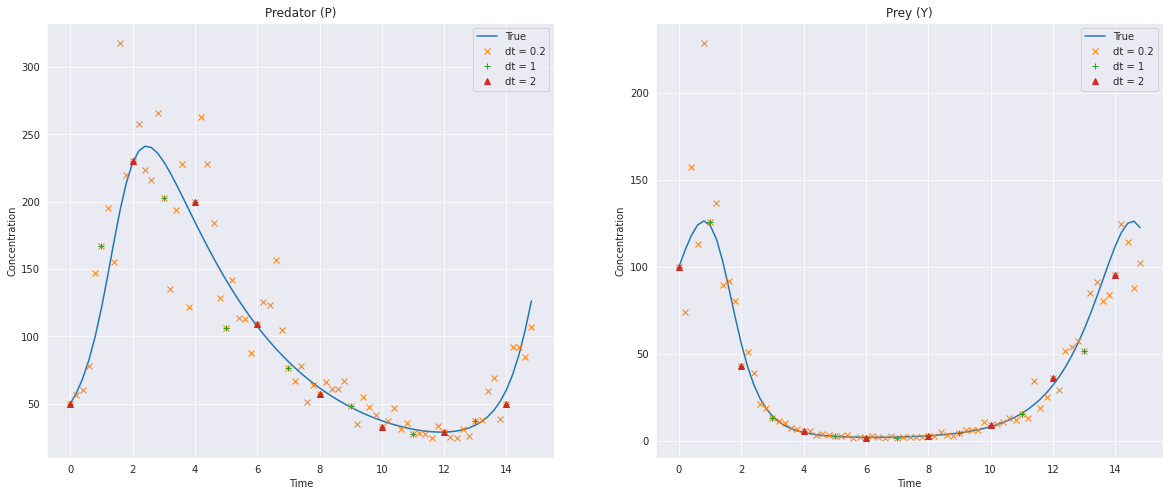

In [15]:
fig, ax = plt.subplots(1, 2)
ax[1].plot(t, Z_obs[:,0], color = 'C0', label = 'True')
ax[0].plot(t, Z_obs[:,1], color = 'C0', label = 'True')
ax[1].plot(t, Z_obs_noisy[:,0], 'x', color = 'C1', label = 'dt = 0.2')
ax[0].plot(t, Z_obs_noisy[:,1], 'x', color = 'C1', label = 'dt = 0.2')
ax[1].plot(t_1, Z_obs_noisy_1[:,0], '+', color = 'C2', label = 'dt = 1')
ax[0].plot(t_1, Z_obs_noisy_1[:,1], '+', color = 'C2', label = 'dt = 1')
ax[1].plot(t_2, Z_obs_noisy_2[:,0], '^', color = 'C3', label = 'dt = 2')
ax[0].plot(t_2, Z_obs_noisy_2[:,1], '^', color = 'C3', label = 'dt = 2')
ax[1].legend()
ax[0].legend()

ax[1].set_title("Prey (Y)")
ax[0].set_title("Predator (P)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Concentration")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Concentration")
fig.set_size_inches(20,8)
plt.savefig("figures/lk_obs.png", dpi = 400)

### Plotting Observations

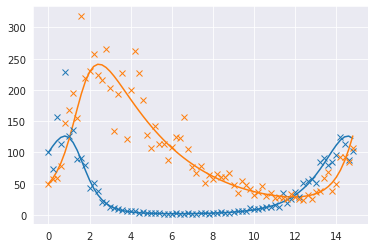

In [8]:
fig, ax = plt.subplots()
ax.plot(t, Z_obs[:,0], color = 'C0', label = 'Prey')
ax.plot(t, Z_obs[:,1], color = 'C1', label = 'Predator')
ax.plot(t, Z_obs_noisy[:,0], 'x', color = 'C0')
ax.plot(t, Z_obs_noisy[:,1], 'x', color = 'C1')

## Non-Regularized Bayesian Linear Regression

In [ ]:
bs_nonregularized = RSINDyNonRegularized(species_names)

In [ ]:
fit, reordered, S,R, D  = bs_nonregularized.fit_dx(
                                                Z_obs,
                                                 t,
                                                 known_S = None,
                                                 known_R = None,
                                                 known_rates = [],
                                                 N = 16,
                                                 model_params = {
                                                    'noise_sigma' : 1
                                                 },
                                                 fit_params = {
                                                    'chains' : 1,
                                                     'iter_warmup' : 3000,
                                                    'show_progress' : 'notebook',
                                                     'variational' : False
                                                 },
                                                 seed = 30
                                               )

In [ ]:
df = fit.summary(sig_figs=5)

In [ ]:
df[df.index.str.contains('^rate')]

## Regularized Horseshoe Bayesian Linear Regression

In [9]:
bs_horseshoe = RSINDyRegularizedHorseshoe(species_names)

In [10]:
t_1, Z_obs_noisy_1 = t[::5], Z_obs[::5]
t_2, Z_obs_noisy_2 = t[::10], Z_obs[::10]
for dt, t_cur, Z_cur in [(0.2, t, Z_obs), (1, t_1, Z_obs_noisy_1), (2, t_2, Z_obs_noisy_2)]:
    fit_horseshoe_dx, _, S_dx, R_dx, D_dx = bs_horseshoe.fit_dx(
                                                         Z_cur,
                                                         t_cur,
                                                         known_S = None,
                                                         known_R = None,
                                                         known_rates = [],
                                                         N = 16,
                                                         model_params = {
                                                            'm0' : 3,
                                                            'slab_scale' : 1,
                                                            'slab_df' : 4,
                                                            'sigma' : 0.0001,
                                                            'noise_sigma' : 1
                                                         },
                                                         fit_params = {
                                                            'chains' : 4,
                                                             'iter_warmup' : 1000,
                                                             'iter_sampling' : 1000,
                                                            'show_progress' : 'notebook',
                                                             'variational' : False
                                                         },
                                                         seed = 30
                                                        )
    fit_horseshoe_dx.save_csvfiles("results/lv")
    full_fit = {"fit": fit_horseshoe_dx, 
            "S" : S_dx, 
            "R" : R_dx, 
            "D" : D_dx
           }
    pickle.dump(full_fit, open("results/lv/horseshoe_dx_{:.1f}.p".format(dt), "wb"))

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/horseshoe_normal_fixed_dx


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/horseshoe_normal_fixed_dx


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/horseshoe_normal_fixed_dx


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

## Non-DX

In [11]:
bs_horseshoe = RSINDyRegularizedHorseshoe(species_names)

In [12]:
t_1, Z_obs_noisy_1 = t[::5], Z_obs_noisy[::5]
t_2, Z_obs_noisy_2 = t[::10], Z_obs_noisy[::10]
for dt, t_cur, Z_cur in [(0.2, t, Z_obs_noisy), (1, t_1, Z_obs_noisy_1), (2, t_2, Z_obs_noisy_2)]:

    fit_horseshoe_ndx, _, S_ndx, R_ndx, D_ndx = bs_horseshoe.fit_non_dx(
                                        Z_cur, 
                                        t_cur,
                                        known_S = None,
                                        known_R = None,
                                        known_rates = [],
                                        N = 16,
                                        model_params = {
                                           'm0' : 3,
                                           'slab_scale' : 1,
                                           'slab_df' : 2,
                                           'sigma' : 0.001,
                                           'noise_sigma' : 0.2
                                        },
                                        fit_params = {
                                           'chains' : 4,
                                            'iter_warmup' : 1000,
                                            'iter_sampling' : 1000,
                                           'show_progress' : 'notebook',
                                            'max_treedepth' : 10,
                                            'variational' : False
                                        },
                                        seed = 30) 
    fit_horseshoe_ndx.save_csvfiles("results/lv")
    full_fit = {"fit": fit_horseshoe_ndx, 
            "S" : S_ndx, 
            "R" : R_ndx, 
            "D" : D_ndx
           }
    pickle.dump(full_fit, open("results/lv/horseshoe_ndx_{:.1f}.p".format(dt), "wb"))

INFO:cmdstanpy:compiling stan program, exe file: /home/rmjiang/Other/bio_sindy/models/tempfile
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/tempfile


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:cmdstanpy:compiling stan program, exe file: /home/rmjiang/Other/bio_sindy/models/tempfile
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/tempfile


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:cmdstanpy:compiling stan program, exe file: /home/rmjiang/Other/bio_sindy/models/tempfile
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/tempfile


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]